In [1354]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage
from PIL import Image

In [1355]:
def read_images(image_path):
    img = cv2.imread(image_path)
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [1356]:
def read_images_color(image_path):
    img = cv2.imread(image_path)
    img = img.astype('float')
    img = img/255
    return img

In [1357]:
def create_compute_shift(img):
    shift_detector = cv2.xfeatures2d.SIFT_create()
    kp, desc = shift_detector.detectAndCompute(img, None)
    return kp, desc

In [1358]:
def calculate_distance(desc_l, desc_r, k_pts_l, k_pts_r, threshold):
    dist = scipy.spatial.distance.cdist(desc_l, desc_r, 'sqeuclidean')
    row, col = np.where(dist<threshold)
    point_l = np.array([k_pts_l[i].pt for i in row])
    point_r = np.array([k_pts_r[i].pt for i in col])
    combine_pts = np.hstack((point_l, point_r))
    return combine_pts

In [1359]:
def residual_error(matching, homography):
    left_img_pts = matching[:,0:2]
    right_img_pts = matching[:,2:4]

    ones = np.ones((matching.shape[0],1))
    left_img_homoginous_coordinates = np.concatenate([left_img_pts, ones], axis=1)

    left_img_transformed = np.matmul(homography,left_img_homoginous_coordinates.T)

    left_img_transformed = left_img_transformed.T
    left_xy = left_img_transformed[:,0:2]
    left_z =  left_img_transformed[:,2].reshape(left_xy.shape[0],1)

    left_transformed_coordinates = left_xy / left_z

    error = np. linalg.norm(right_img_pts - left_transformed_coordinates, axis=1) ** 2

    return error

In [1360]:
def compute_homography(matching_pts):
    temp = []
    for i in range(0, matching_pts.shape[0]):
        x1, y1 = matching_pts[i][0:2]
        x2, y2 = matching_pts[i][2:4]

        row_1 = [x1, y1, 1, 0, 0, 0, -x2*x1, -x2 * y1, -x2]
        row_2 = [0, 0, 0, x1, y1, 1, -y2*x1, -y2* y1, -y2]
        temp.append(row_1)
        temp.append(row_2)

    u, s, v = np.linalg.svd(np.array(temp))
    homography = v[len(v)-1]
    homography = homography.reshape(3,3)

    return homography

In [1361]:
def wrap_image_in_one_coordinate(left_img, right_img, homography):

    p_transform = skimage.transform.ProjectiveTransform(homography)
    h, w, c = right_img.shape
    wrp = skimage.transform.warp

    corners = np.array([[0,0],[0,h],[w,0],[w,h]])
    print(p_transform, h, w)
    transformed_c =  p_transform(corners)

    set_corners = np.vstack((transformed_c,np.array([[0,0],[0,h],[w,0],[w,h]])))

    c_min = np.min(set_corners, axis=0)
    c_max = np.max(set_corners, axis=0)

    output_shape = np.ceil((c_max - c_min)[::-1])

    shift = skimage.transform.SimilarityTransform(translation=-c_min)

    left_img_cval_1 = wrp(left_img, shift.inverse , output_shape = output_shape, cval = -1)
    left_img_cval_0 = wrp(left_img, shift.inverse , output_shape = output_shape, cval = 0)

    right_img_cval_1 = wrp(right_img, (p_transform + shift).inverse , output_shape = output_shape, cval = -1)

    right_img_cval_0 = wrp(right_img, (p_transform + shift).inverse, output_shape = output_shape, cval = 0)

    overlap = (left_img_cval_1 != -1.0).astype(int) + (right_img_cval_1 != -1.0).astype(int)
    overlap += (overlap < 1).astype(int)

    combined_image = (left_img_cval_0+right_img_cval_0)/overlap

    image = np.asarray(Image.fromarray((combined_image * 255).astype(np.uint8), mode='RGB'))

    return image

In [1362]:
def show_mathcing_points(img_left, img_right, pts):
    plane = np.empty((max(img_left.shape[0], img_right.shape[0]), img_left.shape[1]+ img_right.shape[1]), np.uint8)

    plane[:, :img_left.shape[1]] = left_img

    plane[:, img_left.shape[1]:(img_left.shape[1]+ img_right.shape[1])] = right_img

    plt.imshow(plane)
    plt.plot([pts[:,0],pts[:,2]+img_left.shape[1]], [pts[:,1],pts[:,3]])
    plt.show()

In [1363]:
def ransac(img_left, img_right, matches, threshold, iterations):
    max_inline = 0
    homography_matrix =[]
    residual_avg = 0

    for i in range(0,iterations):

        sample_index = np.random.choice(range(0,matches.shape[0]), size=4, replace=False)
        sample = np.array([ matches[index,:] for index in sample_index])
        homography_un_normalized = compute_homography(sample)
        homography = homography_un_normalized/homography_un_normalized[2][2]

        error = residual_error(matches, homography)
        index = np.where(error<threshold)

        points_inliners = matches[index]

        num_inliners = len(points_inliners)
        if max_inline <= num_inliners:
            max_inline = num_inliners
            inliner_pts = points_inliners.copy()
            homography_matrix = homography.copy()
            residual_avg = sum(residual_error(points_inliners, homography))/num_inliners


    print("average residual error for inliers:", residual_avg)
    print("number of inliers:", max_inline)
    show_mathcing_points(img_left, img_right, inliner_pts)

    return homography_matrix


In [1364]:
left_img = read_images('./images/left.jpg')
right_img = read_images('./images/right.jpg')
left_img_color = read_images_color('./images/left.jpg')
right_img_color = read_images_color('./images/right.jpg')
left_key_point, left_descriptor = create_compute_shift(left_img)
right_key_point, right_descriptor = create_compute_shift(right_img)

average residual error for inliers: 0.018984270768781834
number of inliers: 8


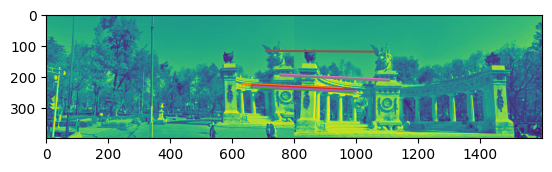

In [1365]:
mathing_points = calculate_distance(left_descriptor, right_descriptor, left_key_point, right_key_point, 6000)
homography_matrix = ransac(left_img, right_img, mathing_points, 0.1,10000)


In [1366]:
img = wrap_image_in_one_coordinate(right_img_color,left_img_color, homography_matrix)

<ProjectiveTransform(matrix=
    [[ 2.30021366e+00,  6.87247197e-02, -1.20879919e+03],
     [ 2.62292247e-01,  2.12094485e+00, -2.34287686e+02],
     [ 7.77073156e-04,  9.91100519e-04,  1.00000000e+00]])> 398 800


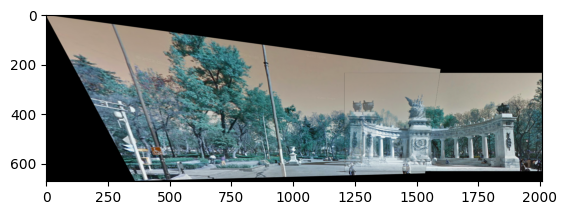

In [1367]:
plt.imshow(img)